In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from typing import Iterable, Dict, List, Tuple
from tqdm import tqdm
import torch

/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
train = pd.read_csv('train.csv')

In [ ]:
train.head()

In [ ]:
train.shape

In [ ]:
# train classifier on tfidf + random forest test in on new dataset => not bad
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(train.text.values)
y = train.target.values

X_train, X_test, y_train, y_test = train_test_split(X,y)

model = RandomForestClassifier(n_estimators=200)
model.fit(X_train, y_train)
model.score(X_test,y_test)

In [3]:
# create a new dataset with the pandas one
class Data(torch.utils.data.Dataset):
    def __init__(self,
                 tokenizer,
                 dataset: pd.DataFrame,
                 batch_size: int = 32,
                 max_len: int = 144):
        self.length = dataset.shape[0]
        self.txts = dataset.text.values
        self.targets = dataset.target.values
        self.batch_size = batch_size
        self.max_len = max_len

    def __getitem__(self, idx) -> Tuple[torch.tensor]:
        txt_list = self.txts[idx:idx + self.batch_size]
        tgt_list = self.targets[idx:idx + self.batch_size]

        logits = []
        targets = []
        for ix, data in enumerate(txt_list):
            # encode with tokenizer
            txt = torch.LongTensor(tokenizer.encode(data))
            # pad with 0 upto max len
            logit = F.pad(txt, pad=(0, self.max_len - txt.size()[0]))
            target = tgt_list[ix]

            logits.append(logit)
            targets.append(target)

        return logits, targets

    def __len__(self):
        return self.length

In [4]:
# Create a model with first layer being Bert and simply a fully connected one
class Model(nn.Module):
    def __init__(self,
                 pretrained: bool = False,
                 batch_size: int = 32,
                 n_hidden_states: int = 768,
                 max_len: int = 256):
        super(Model, self).__init__()

        self.batch_size = batch_size
        self.max_len = max_len
        self.n_hidden_states = n_hidden_states
        self._config = BertConfig()

        if pretrained:
            # init bert with weights from s3
            self.bert_layer = BertModel(
                self._config).from_pretrained('bert/')
        else:
            # init bert without pretrained weights
            self.bert_layer = BertModel(self._config)

        # freeze bert params
        for param in self.bert_layer.parameters():
            param.requires_grad = False
        # init classifying layers
        self.fc1 = nn.Linear(n_hidden_states*max_len, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, item: torch.float32) -> torch.LongTensor:
        out = self.bert_layer.forward(item)
        # >>> out[0].size() == batch_size, max_len, n_hidden_states
        out = out[0]  # select only the last hidden states
        # flatten along the hidden state and `token` dimension
        out = torch.flatten(out, start_dim=1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out

BATCH = 32
MAX_LEN = 144

tokenizer = BertTokenizer(vocab_file="bert/vocab.txt", do_lower_case=True)

model = Model(batch_size=BATCH, max_len=MAX_LEN, pretrained=True).to("cuda")
data = Data(tokenizer=tokenizer, dataset=train, batch_size=BATCH, max_len=MAX_LEN)
loader = torch.utils.data.DataLoader(data)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [7]:
losses = []
for data_ in loader:
    optimizer.zero_grad()
    logits, targets = data_
    logits, targets = torch.cat(logits).to('cuda'), torch.cat(targets).float().to('cuda')
    
    out = model.forward(logits)
    out = out.view(BATCH)
    
    loss = criterion(out, targets)
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()

KeyboardInterrupt: 

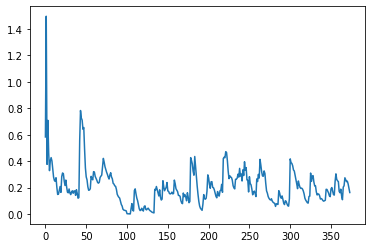

In [21]:
plt.plot(losses)

In [9]:
targets

tensor([0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       device='cuda:0')

In [ ]:
torch.flatten(Bert_out, start_dim=1)

In [ ]:
model